In [98]:

from os import listdir
from os.path import join

from natsort import natsorted
import mne
from pymatreader import read_mat
from eye_cleaner import clean_eye_data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('poster')


In [2]:
#preprocess eye data
eye_path = './data'
all_files = listdir(eye_path)
sorted_files = natsorted(all_files)

raw_all = []

for cur_f in sorted_files:

    data_eye = read_mat(join(eye_path, cur_f))['data']
    raw = clean_eye_data(data_eye,
                        gaze_lims={'x': 6,
                                   'y': 6}, 
                        filter_settings={'pupil_diameter': (None, 30),
                                         'xy_movements': (.1, 40)},)

    raw_all.append(raw)
        

raw_cmb = mne.concatenate_raws(raw_all)

/mnt/obob/staff/fschmidt/playground/eye_cleaner/eye_cleaner.py:108: RuntimeWarning: Mean of empty slice
  df['x'] = np.nanmean([df['Left Eye x'], df['Right Eye x']], axis=0)
/mnt/obob/staff/fschmidt/playground/eye_cleaner/eye_cleaner.py:109: RuntimeWarning: Mean of empty slice
  df['y'] = np.nanmean([df['Left Eye y'], df['Right Eye y']], axis=0)
/mnt/obob/staff/fschmidt/playground/eye_cleaner/eye_cleaner.py:110: RuntimeWarning: Mean of empty slice
  df['diameter'] = np.nanmean([df['Left Eye Pupil Diameter'], df['Right Eye Pupil Diameter']], axis=0)
/mnt/obob/staff/fschmidt/playground/eye_cleaner/eye_cleaner.py:140: RuntimeWarning: The unit for channel(s) STI101 has changed from V to NA.
  raw.set_channel_types({trigger_ch_name: 'stim'},
/mnt/obob/staff/fschmidt/playground/eye_cleaner/eye_cleaner.py:108: RuntimeWarning: Mean of empty slice
  df['x'] = np.nanmean([df['Left Eye x'], df['Right Eye x']], axis=0)
/mnt/obob/staff/fschmidt/playground/eye_cleaner/eye_cleaner.py:109: RuntimeWarn

### Lets explore the eye data returned from "clean_eye_data"

Turning the eye data into a raw instance from mne python is super nice, 
as you can do most operations on the signal that you can also do with m/eeg signals.



9620 events found
Event IDs: [  2   3   4   5   6   7   8   9  12  13  14  15  16  17  18  19  22  23
  24  25  26  27  28  29  32  33  34  35  36  37  38  39  42  43  44  45
  46  47  48  49  52  53  54  55  56  57  58  59  62  63  64  65  66  67
  68  69  72  73  74  75  76  77  78  79  82  83  84  85  86  87  88  89
  92  93  94  95  96  97  98  99 102 103 104 105 106 107 108 109 112 113
 114 115 116 117 118 119 122 123 124 125 126 127 128 129 132 133 134 135
 136 137 138 139 142 143 144 145 146 147 148 149 152 153 154 155 156 157
 158 159 162 163 164 165 166 167 168 169 172 173 174 175 176 177 178 179
 182 183 184 185 186 187 188 189 192 193 194 195 196 197 198 199]


/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 2 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 4 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 6 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 8 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 12 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 13 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 14 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/tmp/ipykernel_10459/3948015779.py:10: RuntimeWarning: event 15 missing from event_id w

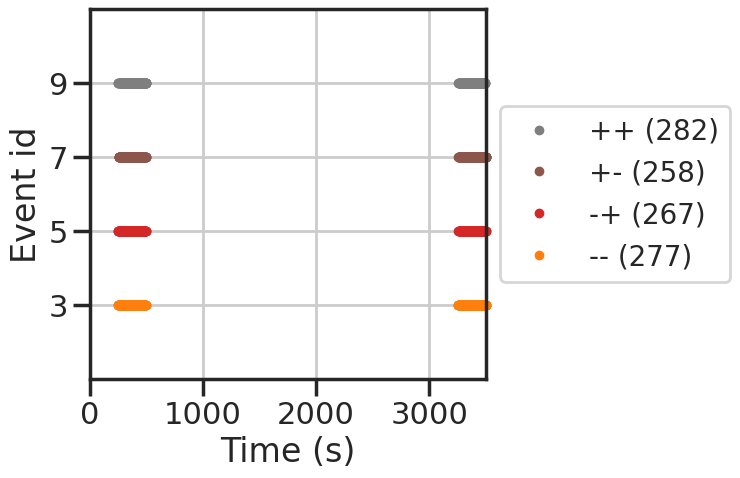

In [63]:
# we have events in the data that we can visualize
# (we have alot of them in this experiment so we will just focus on a few)
# the events we focus on are changes in luminance of gabor gratings from dark "--" to bright "++" 
event_dict = {'--': 3,
              '-+': 5,
              '+-': 7,
              '++': 9}
events = mne.find_events(raw_cmb, stim_channel="STI101")

fig = mne.viz.plot_events(
    events, 
    sfreq=raw_cmb.info["sfreq"], 
    first_samp=raw_cmb.first_samp, 
    event_id=event_dict
)
fig.subplots_adjust(right=0.7)

In [64]:
# we can also use this to chunk the data into epochs 
# NOTE: that bad epoch that were annotated before are removed automatically
epochs = mne.Epochs(raw_cmb, 
                    events,
                    tmin=-1, 
                    tmax=1, 
                    reject_by_annotation=False,
                    event_id=event_dict, preload=True)


Not setting metadata
1084 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1084 events and 4001 original time points ...


0 bad epochs dropped


In [65]:
#and compute some "eye" evoked potentials
# we mainly get 3 different channels from data cleaning
picks=['x', 'y', 'diameter']

df_list = []

for key in event_dict.keys():
    cur_df = epochs[key].average(picks=picks).to_data_frame()
    cur_df['condition'] = key
    df_list.append(cur_df)

df_evoked = pd.concat(df_list)

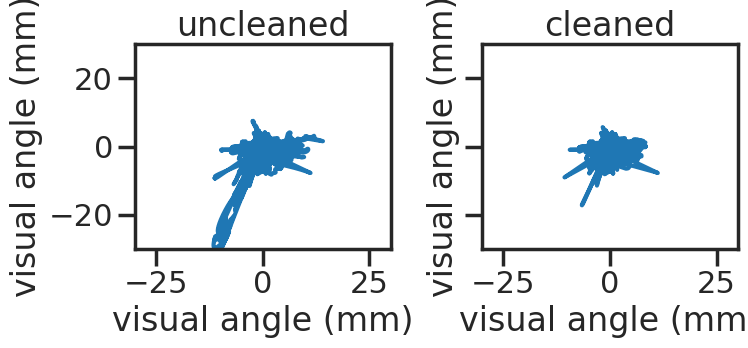

In [68]:
# We can also visualize the impact of our cleaning decisions
df_eye = raw_cmb.to_data_frame()
f, axes = plt.subplots(ncols=2, 
                     figsize=(8,4),
                     sharex=True,
                     sharey=True)

axes[0].plot(df_eye['x'], 
             df_eye['y'])

axes[1].plot(df_eye['x'][df_eye['xy_thd'] == 0], 
             df_eye['y'][df_eye['xy_thd'] == 0])

for ax, title in zip(axes, ['uncleaned', 'cleaned']):
    ax.set_title(title)
    ax.set_ylabel('visual angle (mm)')
    ax.set_xlabel('visual angle (mm)')
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)


f.tight_layout()